# 25-Relief Action

Learning Objectives:
- Use orifice flow estimates in mass and energy balance calculations
- Estimate vent sizing for deflagrations
- Gain experience with mass and energy balance principles
- Review relief requirements for fire scenarios


Review of MAWP and max accumulation pressure or max overpressure (based on gauge pressure)

## Venting for External Fires

As heat is input to the vessel, the liquid warms and expands and reaches the boiling point. The mass flow of vapor at that point is:

$$
Q_m = Q/\Delta H_{vap}
$$

where $Q_m$ is the mass flow of vapor, $Q$ is the heat input (estimated from Eq 10-34 and 10-35 in Crowl and Louvar), and $\Delta H_{vap}$ is the heat of vaporization. The vent area can then be sized based on the mass flow of vapor. 

When the liquid is heated it expands according to the thermal expansion coefficient, $\beta$. The volume of the liquid is:

$$
V = V_0(1+\beta \Delta T)
$$

where $V_0$ is the initial volume, $\beta$ is the thermal expansion coefficient, and $\Delta T$ is the temperature change. This is found from the definition of the thermal expansion coefficient:

$$
\beta = \frac{1}{V_0}\frac{dV}{dT}
$$


## Orifice Flow and Mass Balances

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### First Example

Consider a 20L sphere where the methane is combusted with at least as much air as is stoichiometrically required. The combustion is complete and the products are:

$$
CH_4 + 2O_2 \rightarrow CO_2 + 2H_2O
$$

Three moles of reactants produce 3 moles of products. At higher temperatures, the water vapor will be in the gas phase and there can be radicals. For the example here, we will assume that the water stays in the vapor phase and that the combustion is complete such that there is no overall change in the number of moles of gas.

What is the final pressure and temperature if there is no heat loss and the reaction rate is constant at 15 moles/sec/m3?

```{note}
Some simplifying assumptions:
- The burn rate is proportional to the total moles not just the moles of methane
- The burn rate transitions monotonically from it's highest value to zero instead of a step change
```

Here is a an image of the notebook thoughts on the scenario and the mass and energy balance:

<img src="https://github.com/clint-bg/safetyinjc/blob/main/physical/supportfiles/EnergyNoVent.png?raw=trueg" width="600">

The below hidden code cell contains:
- parameters for the 20L sphere and combustion reaction estimate (simplified)
- the sigmoid function for the burn rate (transition from full burn to zero at the end of the burn)
- the derivative function to be integrated
- the initial conditions
- the integration and solution

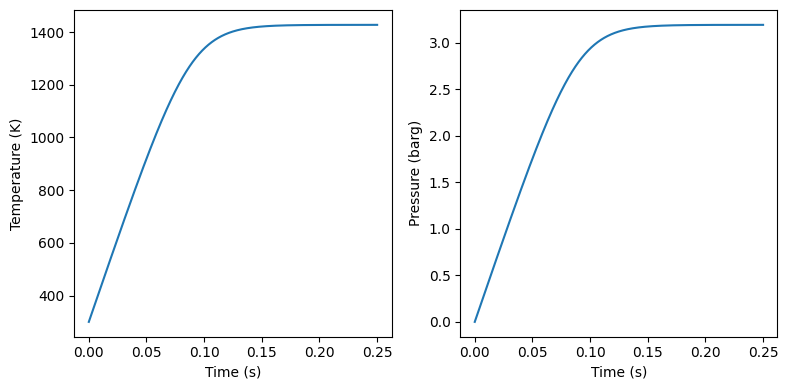

In [2]:
#first scenario with 20 liter sphere with methane and air
#     assume constant burn rate per total moles
#     3 moles (CH4 and 2O2) react to yield 3 moles (CO2 and 2H2O) thus dn/dt = in - out + gen = 0

k = 15 #1/sec/m3, estimate of reaction rate of methane and air, assumed constant burn rate
tburn = 0.1 #seconds, time to burn 20 liters of methane (rough estimate only)
V = 20/1000 #20 liter sphere to m^3
DH_rx = 890.4*1000 #J/mol CH4 , heat of combustion
Tinitial = 300 #K, initial temperature of sphere
Pinitial = 85000 #Pa, initial pressure of sphere
Rg = 8.314 #J/mol*K, ideal gas constant
n = Pinitial*V/(Rg*Tinitial) #moles of gas in sphere
Cv = 5/2*Rg #J/mol*K, heat capacity at constant volume (estimate for gases)
gamma = 1.4 #ratio of specific heats (estimate)
#energy balance: d(nU)/dt = gen = kV DH_rx 

def sigmoid(x, t_switch): #at t_switch, the sigmoid function will be 0.67
    return 1/(1+np.exp(-5.708/t_switch*x+5))

def derivatives(var, time):
    T = var
    dTdt = n*k*V*DH_rx/(n*Cv)*(1-sigmoid(time, tburn))
    return dTdt

time = np.linspace(0, 0.25, 1000)
T = odeint(derivatives, Tinitial, time).T[0]
P = n*Rg*T/V

#plot temperature and pressure in two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(time, T)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Temperature (K)')
ax[1].plot(time, P/1e5 - Pinitial/1e5)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Pressure (barg)')
plt.tight_layout()
plt.show()



See this reference for more detailed information on combustion of methane in a 20L and larger spheres: https://doi.org/10.1016/j.jlp.2017.02.022 

## Second Example (Follow-on from First Example)

Consider the same conditions as the first example but what burst disk size would be required to prevent the pressure from exceeding 1 barg?

```{note}
Some simplifying assumptions:
- The above assumptions apply
- Assume that the area of the burst disk transitions from closed to open in a s-curve fashion once the burst pressure of the disk is reached with a parameter of $t_{open}$ equal to the time that the burst disk is 67% open. This is also applied to the burn rate of the fuel.
```

You can download a pdf of the in-class notes here (including both the instructor and in-class version): https://github.com/clint-bg/safetyinjc/blob/main/physical/supportfiles/EnergyMassVent.pdf 


Additional parameters for the venting of the volume once the pressure reaches the burst pressure of the disk.

In [3]:
#Burst disk function
t_open = 0.1 #seconds, time to open burst disk to 67%
Pdisk = 2e5 #Pa, burst disk pressure, 1barg
Area_f = np.pi/4*(0.08)**2 #m^2, area of burst disk
barea = lambda t: Area_f*sigmoid(t,t_open) #sigmoid function to open burst disk
Cd = 0.95 #discharge coefficient

```{warning}
The below code will give non-realistic answers if the vent time is faster than the burn time. Vent time meaning the pressure is relieved prior to the burn completing.
```

The area of the burst disk changes with time as it opens and moves out of the way. That transition is also estimated with a sigmoid function (it could also be done with using physics where F = P/A = m*a  and you can step through time as the burst disk moves). The area of the burst disk is shown in the below figure.

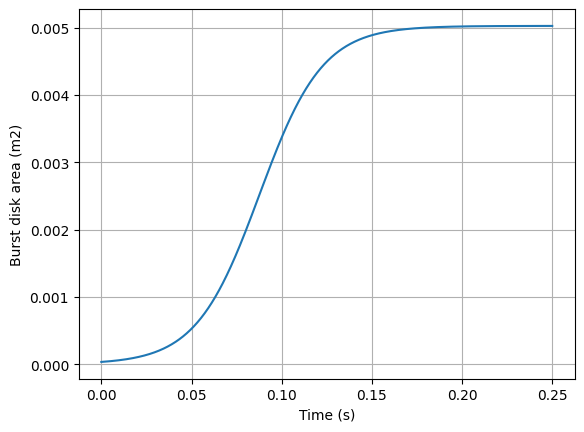

In [4]:
#plot burst disk area
plt.plot(time, barea(time))
plt.xlabel('Time (s)')
plt.ylabel('Burst disk area (m2)')
plt.grid()
plt.show()

The below hidden code cell contains the moles of gas flowing out of the vent. The flow is based on the general equations discussed in the previous lecture. There's also an if statement such that if the pressure drops below the atmospheric value, there's flow of gas into the container from the atmosphere.

In [5]:
def nout(T,P,A):
    if P>Pinitial:
        ratio = P/Pinitial
        Pdrive = P
    else:
        ratio = Pinitial/P
        Pdrive = -Pinitial
    Ma = min(1,np.sqrt(2/(gamma-1)*((ratio)**((gamma-1)/gamma)-1)))
    Mw = 0.03 #kg/mol, molecular weight of gases estimate
    flow = Pdrive*A*Cd*Ma*np.sqrt(gamma/(Rg*T*Mw))*(1+(gamma-1)/2*Ma**2)**((gamma+1)/(2-2*gamma))
    return flow
    

The below code cell shows the derivatives for moles and temperature for the venting. There's also if statements to account for the changing conditions when the burst disk ruptures and the relative sizes of the internal and external pressures.

In [6]:
#dndt = in - out + gen = - nout (burst disk)
#dnUdt = in - out + gen = - nout (burst disk)*H + Hrxn*r*V
time_offset = 0.; flag = 0
def derivatives(var, t):
    global time_offset, flag
    n,T = var
    P = n*Rg*T/V
    dTdt = n*k*V*DH_rx/(n*Cv)*(1-sigmoid(t,tburn))
    if P<Pdisk and flag == 0: #disk intact
        time_offset = t #time_offset is the time when the disk breaks and used for the sigmoid function
        dndt = 0
    else:
        if flag == 0: #disk broken
            flag = 1
        dndt = -nout(T,P,barea(t-time_offset)) #flow out through the vent
        if P>Pinitial: #case when air is pushed out
            dTdt = dTdt + dndt*Rg*T/(n*Cv)
        else: #case when air is sucked in (estimate of enthapy change)
            dTdt = dTdt + dndt*Rg*Tinitial/(n*Cv)
    return dndt, dTdt

The below code cell shows the integration and solution for the venting of the volume once the pressure reaches the burst pressure of the disk.

In [7]:
#Integration, initial value problem
init = [n, Tinitial]
sol = odeint(derivatives, init, time).T
[ns,Ts] = sol
Ps = ns*Rg*Ts/V

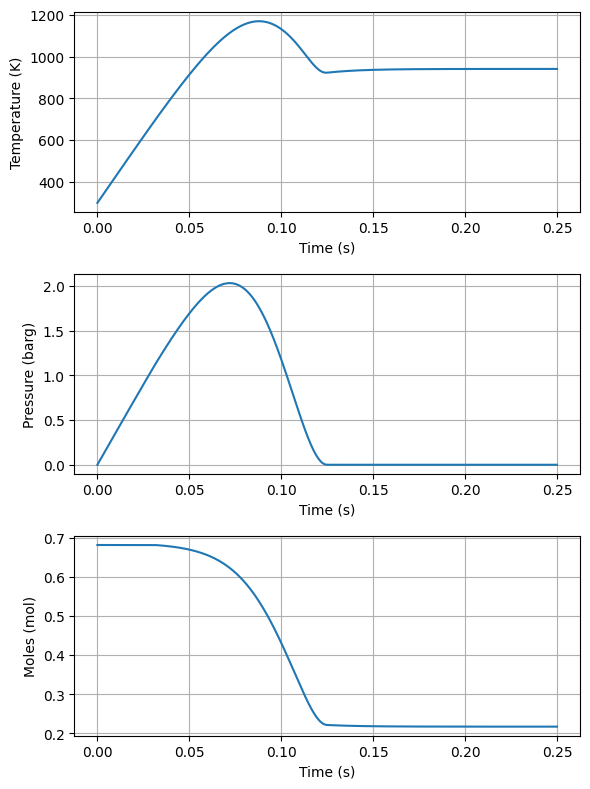

In [8]:
#plot temperature and pressure in two plots side by side
fig, ax = plt.subplots(3, 1, figsize=(6, 8))
ax[0].plot(time, Ts)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Temperature (K)')
ax[0].grid(True)
ax[1].plot(time, Ps/1e5 - Pinitial/1e5)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Pressure (barg)')
ax[1].grid(True)
ax[2].plot(time, ns)
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Moles (mol)')
ax[2].grid(True)
plt.tight_layout()
plt.show()

Notice how the pressure exceeds the burst pressure of the disk substantially as the energy from the burning is larger than that that can be vented. The accumulation and overpressure discussed in the previous lectures can be found knowing the MAWP of the vessel and the set pressure of the disk.

```{note}
The above example is an integrated solution to the approximate behavior of the burning and of the opening of the vent. Actual vent sizing for explosions can be more nuanced and is not covered in detail here. This is a simplified example to demonstrate some fundamental principles of kinetics, thermodynamics, and numerical methods with many simplifying assumptions.
```